# NCO Algorithm
## Imports

In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.linalg import block_diag

import warnings
warnings.filterwarnings("ignore")

## Import py file

In [3]:
import RiskLabAI.optimization.nco as nco
import RiskLabAI.data.denoise.denoising as denoising

## Composition of the diagonal correlation matrix

This cell shows how to form a block-diagonal correlation matrix of different numbers of blocks, block sizes, and intrablock correlations.

3.0


<Axes: >

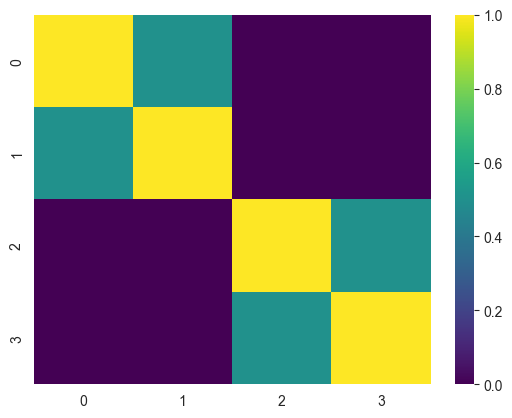

In [4]:
corr0 = denoising.form_block_matrix(2, 2, .5)
eigen_values, eigen_vectors = np.linalg.eigh(corr0)
print(max(eigen_values) / min(eigen_values))
sns.heatmap(corr0, cmap="viridis")

## Block-Diagonal Correlation Matrix with a Dominant Block

This cell demonstrates that reducing the intrablock correlation in only one of the two blocks does not decrease the condition number.

In [5]:
corr0 = block_diag(denoising.form_block_matrix(1, 2, .5))
corr1 = denoising.form_block_matrix(1, 2, .0)
corr0 = block_diag(corr0, corr1)
eigen_values, eigen_vectors = np.linalg.eigh(corr0)
print(max(eigen_values) / min(eigen_values))

3.0


## Running NCO Algorithm
In following cells, we will demonstrate the NCO algorithm.
### 1. Correlation Clustering
First step is to cluster the correlation matrix and that means to group the assets that have high correlation with each other.

In [6]:
all_stocks = pd.DataFrame()
stocks = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "JPM", "UNH",
          "V", "JNJ", "HD", "WMT", "PG", "BAC", "MA", "PFE", "DIS", "AVGO",
          "XOM", "ACM", "CSCO", "NFLX", "NKE", "LLY", "KO", "TMO", "CRM", "COST", "AAL"]
for symb in stocks:
    data = pd.DataFrame(yf.Ticker(symb).history(start="2019-01-01", end="2021-08-08")['Close']).transpose()
    if symb == 'BTC-USD':
        all_stocks = data.copy()
    else:
        all_stocks = pd.concat([all_stocks, data], axis=0)
all_stocks.index = [stocks]
all_stocks = all_stocks.transpose()
all_stocks = all_stocks.pct_change(1)

In [7]:
cov0 = all_stocks.cov()
cols = cov0.columns
cov1 = denoising.denoise_cov(cov0, all_stocks.shape[0] / all_stocks.shape[1], bandwidth=.01)  # de-noise cov
cov1 = pd.DataFrame(cov1, index=cols, columns=cols)
corr1 = denoising.cov_to_corr(cov1)
corr1, clusters, silh = nco.cluster_k_means_base(corr1, number_clusters=int(corr1.shape[0] / 2), iterations=10)

### 2. Intracluster Weights

The next step is to calculate the optimal intracluster weights.

In [8]:
w_intra = pd.DataFrame(0, index=cov1.index, columns=clusters.keys())
for i in clusters:
    w_intra.loc[clusters[i], i] = nco.get_optimal_portfolio_weights(cov1.loc[clusters[i], clusters[i]]).flatten()
w_intra

,0,1
AAPL,0.000000,0.038483
MSFT,0.000000,0.048928
GOOG,0.000000,0.052074
AMZN,0.000000,0.052952
TSLA,0.000000,0.010168
JPM,0.000000,0.035032
UNH,0.108051,0.000000
V,0.000000,0.051802
JNJ,0.258808,0.000000
HD,0.138392,0.000000


In [9]:
cov2 = w_intra.T.dot(np.dot(cov1, w_intra))  # reduced covariance matrix
cov2

,0,1
0,5.202742e-05,-2.840252e-20
1,-2.913226e-20,1.931459e-05


### 3. Intercluster Weights
Finally, we calculate the optimal intercluster allocations using reduced covariance matrix.

In [10]:
w_inter = pd.Series(nco.get_optimal_portfolio_weights(cov2).flatten(), index=cov2.index)
w_inter

0    0.270732
1    0.729268
dtype: float64

In [11]:
w_all0 = w_intra.mul(w_inter, axis=1).sum(axis=1).sort_index()
w_all0

AAL     0.006801
AAPL    0.028064
ACM     0.022858
AMZN    0.038617
AVGO    0.022698
BAC     0.020942
COST    0.071857
CRM     0.023995
CSCO    0.036143
DIS     0.027994
GOOG    0.037976
HD      0.037467
JNJ     0.070068
JPM     0.025548
KO      0.056533
LLY     0.031638
MA      0.028215
MSFT    0.035681
NFLX    0.022552
NKE     0.034137
PFE     0.050933
PG      0.062840
TMO     0.040539
TSLA    0.007415
UNH     0.029253
V       0.037777
WMT     0.066783
XOM     0.024676
dtype: float64

##  Wrapper implementation 
The method get_optimal_portfolio_weights_nco is a wrapper around the three steps above. 

In [12]:
nco.get_optimal_portfolio_weights_nco(cov1)

array([[0.02806418],
       [0.03568139],
       [0.03797622],
       [0.03861652],
       [0.00741528],
       [0.02554794],
       [0.02925279],
       [0.03777716],
       [0.07006783],
       [0.03746706],
       [0.06678253],
       [0.06283955],
       [0.02094187],
       [0.0282149 ],
       [0.05093319],
       [0.027994  ],
       [0.02269779],
       [0.02467568],
       [0.02285841],
       [0.03614341],
       [0.02255228],
       [0.03413655],
       [0.0316383 ],
       [0.05653312],
       [0.04053874],
       [0.02399475],
       [0.07185722],
       [0.00680136]])

## Minimum Variance Portfolio
In the following cells, we will demonstrate the minimum variance portfolio using the NCO algorithm and then compare the results with Markowitz's solution. Here are the steps:

### 1. Form a true matrix
In this step, we will form a true matrix with 5 blocks, each of size 6, and an intrablock correlation of 0.5.

In [13]:
n_blocks, b_size, b_corr = 5, 6, .5
np.random.seed(0)
mu0, cov0 = denoising.form_true_matrix(n_blocks, b_size, b_corr)

### 2. Simulate the covariance matrix
In this step, we will simulate the covariance matrix using the true matrix. Then we will calculate the optimal portfolio weights using the NCO algorithm.

In [14]:
n_obs, n_sims, shrink, min_var_portf = 1000, 10, False, True
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(n_sims), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(n_sims):
    mu1, cov1 = denoising.simulates_cov_mu(mu0, cov0, n_obs, shrink=shrink)
    mu1 = None if min_var_portf else mu1
    w1.loc[i] = nco.get_optimal_portfolio_weights(cov1, mu1).flatten()
    w1_d.loc[i] = nco.get_optimal_portfolio_weights_nco(cov1, mu1, int(cov1.shape[0] / 2)).flatten()

### 3. Compare the results
In this step, we will compute the true minimum variance portfolio from the true covariance matrix and then compute the root-mean-square errors `RMSE` across all weights.

In [15]:
w0 = nco.get_optimal_portfolio_weights(cov0, None if min_var_portf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)
rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** .5  # RMSE
rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** .5  # RMSE
print(rmsd, rmsd_d)

0.01054344414490388 0.006339661481606049


## Maximum Sharpe Ratio Portfolio
Here by setting the `min_var_portf` to `False`, we will calculate the maximum Sharpe ratio portfolio.

In [16]:
n_obs, n_sims, shrink, min_var_portf = 1000, 10, False, False
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(n_sims), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(n_sims):
    mu1, cov1 = denoising.simulates_cov_mu(mu0, cov0, n_obs, shrink=shrink)
    mu1 = None if min_var_portf else mu1
    w1.loc[i] = nco.get_optimal_portfolio_weights(cov1, mu1).flatten()
    w1_d.loc[i] = nco.get_optimal_portfolio_weights_nco(cov1, mu1, int(cov1.shape[0] / 2)).flatten()

In [17]:
w0 = nco.get_optimal_portfolio_weights(cov0, None if min_var_portf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)
rmsd = np.mean((w1 - w0).values.flatten() ** 2) ** .5  # RMSE
rmsd_d = np.mean((w1_d - w0).values.flatten() ** 2) ** .5  # RMSE
print(rmsd, rmsd_d)

0.030521313303819072 0.016857356248061773
